In [1]:
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.simulator import Simulator, generate_sim_config
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.observer import Observer
from deorbit.utils.constants import EARTH_RADIUS
from deorbit.utils.plotting import plot_heatmap


This notebook exists to show how a heatmap of potential landing sites can be generated using the covariances at varying steps before the crash.

In [2]:
save_path = "eg/EKF_example_3D/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

np.random.seed(0)
start_direction = np.random.normal(size=2)
start_direction /= np.linalg.norm(start_direction)
if sim_data is None or sim_config is None:
    rollout_sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 0, *(start_direction * 7820))),
        noise_types = {"gaussian": {"noise_strength": 0.001}, "impulse": {"impulse_strength": 0.005, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = rollout_sim.gather_data()
    sim_config = rollout_sim.export_config()
    rollout_sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


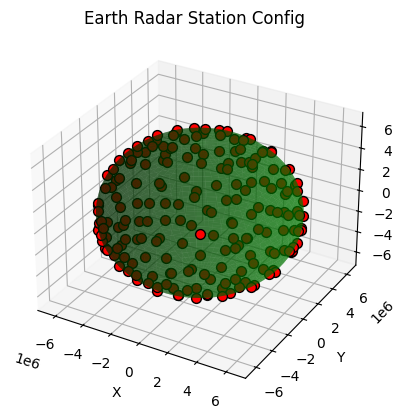

In [3]:
#initialising observer class with sim data
np.random.seed(4)
obs = Observer(number_of_radars=200, dim=3, radar_position_std_per_distance=0.002, radar_velocity_std_per_speed=0.0005)

sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)

observation_times = obs.observed_times
observation_states = obs.observed_states
observed_covariances = obs.observed_covariances

observations = (observation_states, observation_times)
#dim = sim_data.state_array().shape[1]

obs.plot_config()


In [4]:


# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])#process noise
P = np.eye(sim_data.state_array().shape[1]) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly??????) -- for now
H = np.eye(sim_data.state_array().shape[1])

dt = sim_config.simulation_method_kwargs.time_step

#initialising 3D EKF
ekf = EKF(dim=3)

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H)

100%|██████████| 129/129 [00:08<00:00, 15.38it/s]


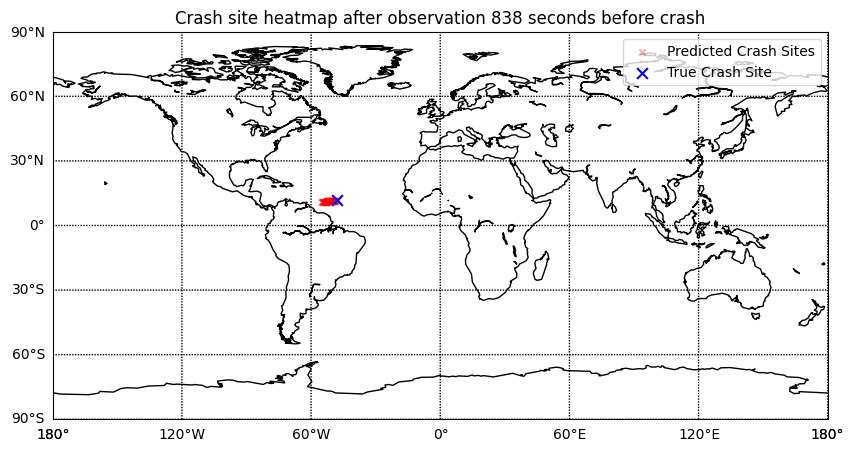

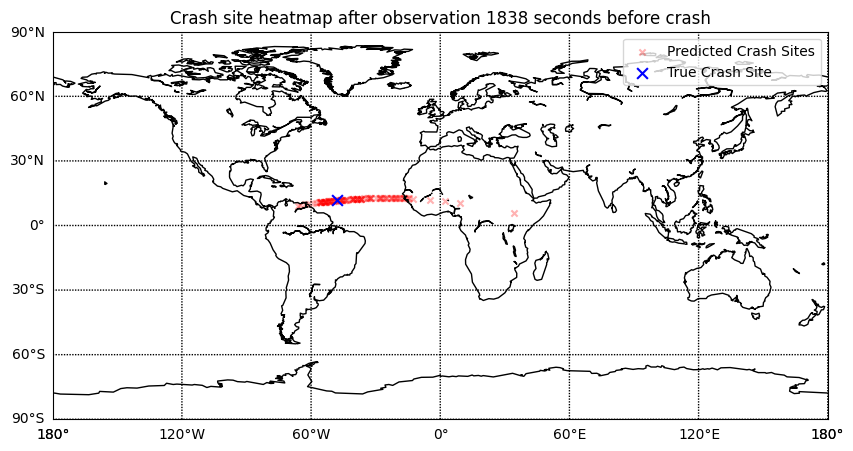

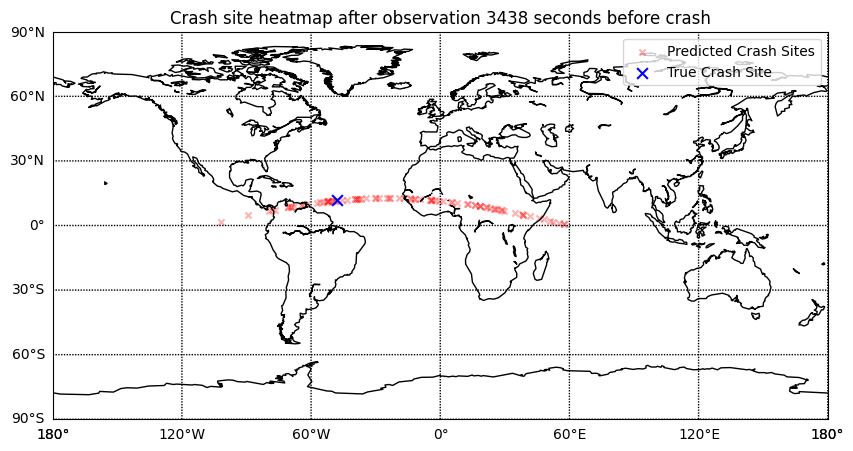

In [5]:
observations_to_check = [-2, -7, -14]
crashes, crash_times = plot_heatmap(sim_states, sim_times, estimated_traj, estimated_times, observations_to_check, observation_times, uncertainties)

In [6]:
for crash, crash_time in zip(crashes, crash_times):
    total_std = np.mean(np.std(crash, axis=0))
    print(f"total std: {total_std}")

total std: 82388.01715283215
total std: 804018.6394479362
total std: 2644993.2535248473
